# New York City Taxi Trip Duration

### 🚣‍♂️목적 
 
### 🧩특징 

### 📔코드북

[출처] <a href="https://www.kaggle.com/code/drgilermo/dynamics-of-new-york-city-animation">New York City Taxi Trip Duration</a>

## Step 1. 필요한 패키지와 데이터셋 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

id_container
sample_submission.csv
test.csv
train.csv



In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


![USA_New_York_City_location_map](2.png)

### 시가지에서 먼 교외 좌표 제거

In [4]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
train = train[(train.pickup_longitude > xlim[0]) & (train.pickup_longitude < xlim[1])]
train = train[(train.dropoff_longitude > xlim[0]) & (train.dropoff_longitude < xlim[1])]
train = train[(train.pickup_latitude > ylim[0]) & (train.pickup_latitude < ylim[1])]
train = train[(train.dropoff_latitude > ylim[0]) & (train.dropoff_latitude < ylim[1])]

* Rides가 밀집되어있는 지역은 Manhattan 지역
* 뉴욕에서는 택시가 크게 2가지 종류가 있음
    1. 주로 멘하탄에 있는 `Yellow taxi`
    2. 외부에서 들어오는 `Green taxi`

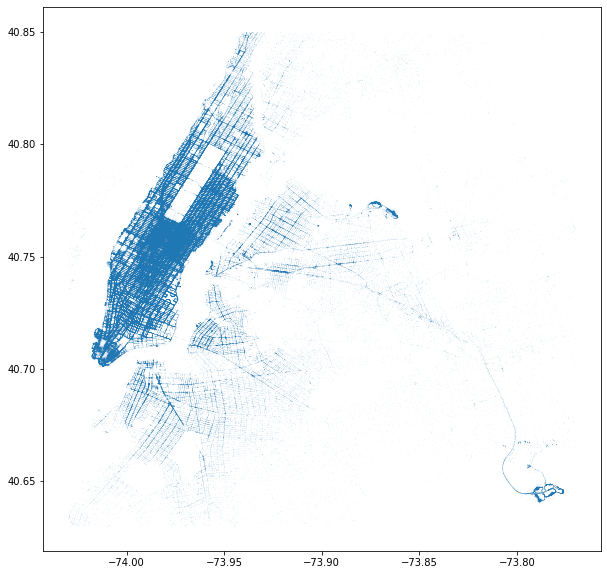

In [5]:
longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

In [6]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

## k-means algorithm  
비슷한 성질의 데이터를 집단으로 나누는 방법을 클러스터링이라고 한다.  

* k-means alogorithm의 학습과정  
    1. 데이터 포인트 중 적장한 점을 집단 개수만큼 선택해 중심으로 정함
        * 집단 개수: 하이퍼 파라미터
        * 집단 개수를 명확하게 정하기 어렵다면 엘보법(elbow method) 등을 사용해 집단 개수를 짐작할 수 있음
    2. 데이터 포인트와 각 중심 사이의 거리를 계산해 가장 가까운 중심을  
       해당 데이터 포인트가 속한 집단으로 정함  
    3. 집단마다 데이터 포인트의 평균을 계산하고 이를 새로운 중심으로 정함
        * 초기값으로 선택한 중심들이 너무 가까이 있을 때 등의 상황으로 정상적인 학습이 어려울 수 있음
        * 가능하면 거리가 먼 중심들로 초기값을 선택하는 k-means++ 알고리즘을 이용해 문제 해결  
    4. 데이터 포인트 모두가 속한 집단이 변하지 않거나 더는 계산할 수 없을 때까지 과정 2, 3을 반복함

### Cluster

각 택시 승하차 지점을 기준으로 뉴욕시를 클러스터링함

In [7]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)

In [8]:
loc_df
loc_df['label'] = kmeans.labels_

In [9]:
loc_df

,longitude,latitude,label
0,-73.982155,40.767937,11
1,-73.980415,40.738564,3
2,-73.979027,40.763939,11
3,-74.010040,40.719971,13
4,-73.973053,40.793209,1
...,...,...,...
2877247,-73.994911,40.740170,9
2877248,-73.970184,40.796547,1
2877249,-74.004433,40.707371,13
2877250,-73.974632,40.757107,6


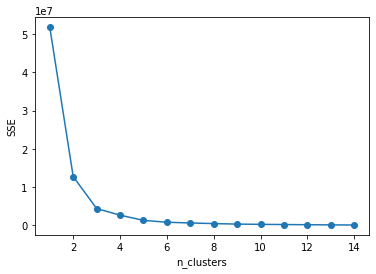

In [10]:
def elbow(data):
    sse = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(data)
        sse.append(kmeans.inertia_)  # inertia, SSE(오차제곱합): 데이터 포인트와 클러스터에 속한 샘플 사이의 거리의 제곱 합

    plt.plot(range(1, 15), sse, marker="o")
    plt.xlabel('n_clusters')
    plt.ylabel('SSE')
    plt.show()

elbow(loc_df)

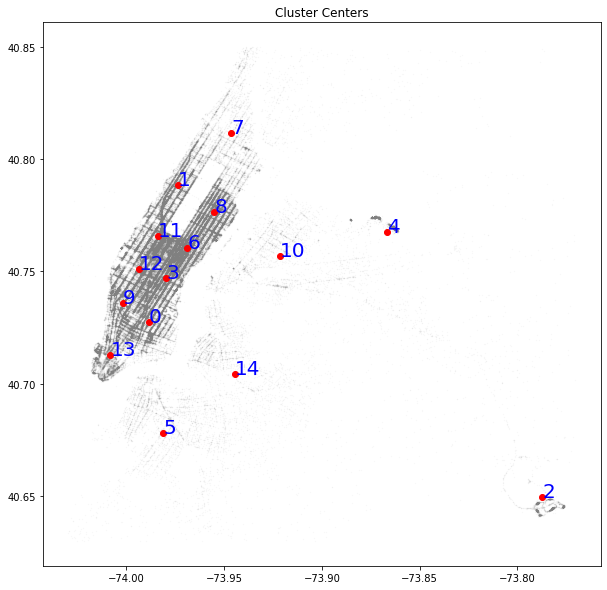

In [11]:
loc_df = loc_df.sample(200000)
fig, ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [15]:
train['pickup_cluster'] = kmeans.predict(train[['pickup_longitude','pickup_latitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_longitude','dropoff_latitude']])
train['pickup_hour'] = train.pickup_datetime.apply(lambda x: parser.parse(x).hour)  # parser.parse() 문자열에서 날짜로 지정하기

In [16]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))